In [ ]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

--2021-12-18 05:41:13--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.34K  --.-KB/s    in 0s      

2021-12-18 05:41:14 (23.3 MB/s) - ‘cifar.py’ saved [2396/2396]



In [ ]:
from torch.utils.data import DataLoader 
import torch
from torch import nn
import cv2

In [ ]:
import numpy as np
from cifar import load_cifar10

X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape, y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


In [ ]:
X_train, X_val, X_test = map(lambda x: (np.transpose(x, [0, 2, 3, 1]) * 255).astype(np.uint8), (X_train, X_val, X_test))

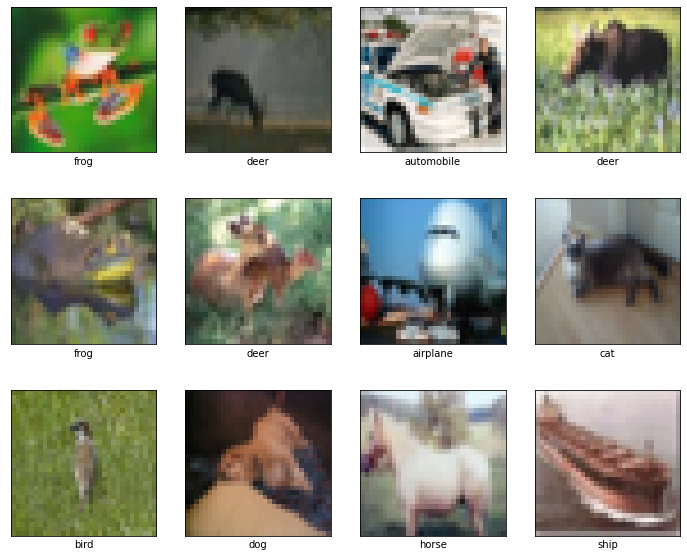

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i])

In [ ]:
import albumentations as albu

In [ ]:
dummy_augs = [
    albu.RandomRotate90(p=1),
    albu.RandomBrightnessContrast(p=1),
    albu.VerticalFlip(p=1),
]

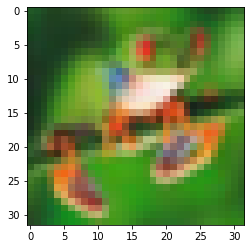

In [ ]:
img = X_train[0]
plt.imshow(img)

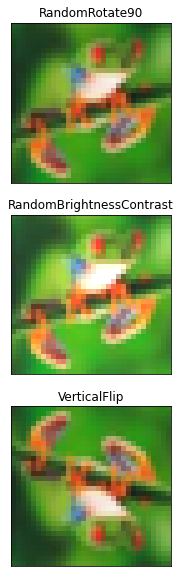

In [ ]:
plt.figure(figsize=(10, 10))
for aug_num, aug in enumerate(dummy_augs):
    augmented_image = aug(image=img)['image']
    plt.subplot(len(dummy_augs), 1, aug_num + 1)
    plt.title(aug.__class__.__name__)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(augmented_image)

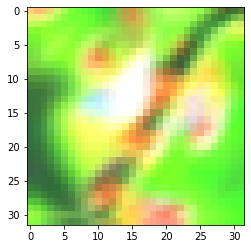

In [ ]:
train_augs = albu.Compose(
    [
       albu.RandomRotate90(p=0.5),
       albu.RandomBrightnessContrast(p=0.8, brightness_limit=1, contrast_limit=1),
       albu.ShiftScaleRotate(p=0.5),
       albu.OneOf(
           [
              albu.MotionBlur(p=1),
              albu.MedianBlur(p=1),
           ], 
           p=0.8,
       )
    ]
)

plt.imshow(train_augs(image=img)['image'])

### Dataset

In [ ]:
img.shape

(32, 32, 3)

In [ ]:
def onehot(size, target):
    vec = np.zeros(size)
    vec[target] = 1
    return vec

def preprocess(im: np.ndarray) -> np.ndarray:
    im = im.astype(np.float32)
    im /= 255 
    im = np.transpose(im, (2, 0, 1))
    im -= np.array([0.485, 0.456, 0.406])[:, None, None]
    im /= np.array([0.229, 0.224, 0.225])[:, None, None]
    return im

class Dataset:
    def __init__(
        self, 
        images,
        labels,
        augmentations,
        preprocess,
    ):
        self._images = images
        self._labels = labels
        self._augmentations = augmentations
        self._preprocess = preprocess

    def __getitem__(self, idx):
        img = self._images[idx]
        label = self._labels[idx]
        if self._augmentations:
            img = self._augmentations(image=img)['image']
        if self._preprocess:
            img = self._preprocess(img)

        return img, onehot(10, label)

    def __len__(self):
        return len(self._images)


In [ ]:
train_augs = albu.Compose(
    [
       albu.RandomRotate90(p=0.5),
       albu.RandomBrightnessContrast(p=0.8, brightness_limit=1, contrast_limit=1),
       albu.ShiftScaleRotate(p=0.5),
       albu.OneOf(
           [
              albu.MotionBlur(p=1),
              albu.MedianBlur(p=1)
           ], 
           p=0.5,
       )
    ]
)

In [ ]:
dummy_dataset = Dataset(X_train, y_train, train_augs, None)

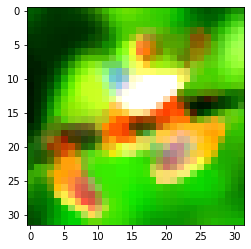

In [ ]:
plt.imshow(dummy_dataset[0][0])

In [ ]:
from torchvision.models import resnet18
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

In [ ]:
from tqdm import tqdm

def train_epoch(
    model,
    train_dataloader,
    criterion,
    optimizer,
    device,
):
    model.train()  
    model.to(device)
    for img_batch, target_batch in train_dataloader:
        img_batch = img_batch.to(device)
        target_batch = target_batch.to(device)
        y_predicted = model(img_batch)
        loss = criterion(y_predicted, target_batch.long().float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def val_epoch(
    model,
    val_dataloader,
    device,
):
    model.eval()
    model.to(device)
    predicts = np.empty(0)
    targets = np.empty(0)
    for img_batch, target_batch in val_dataloader:
        img_batch = img_batch.to(device)
        target_batch = target_batch.to(device)
        with torch.no_grad():
            y_predicted = model(img_batch)
        y_predicted = y_predicted.cpu().data.numpy().argmax(1)
        predicts = np.append(predicts, y_predicted)
        targets = np.append(targets, target_batch.cpu().data.numpy().argmax(1))
    accuracy = (predicts == targets).mean()
    return accuracy

def train_model(
    model, 
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    scheduler, 
    n_epochs,
    best_model_path,
    device,
):
    best_metric = float('-inf')
    metric_history = []
    pbar = tqdm(range(n_epochs), total=n_epochs)
    for epoch in pbar:
        train_epoch(model, train_dataloader, criterion, optimizer, device)
        metric = val_epoch(model, val_dataloader, device)
        if isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        else:
            scheduler.step(metric)
        metric_history.append(metric)
        if metric > best_metric:
            best_metric = metric
            torch.save(
                {
                    'state_dict': model.state_dict(),
                    'metric': best_metric,
                    'epoch': epoch,
                },
                best_model_path,
            )
            pbar.set_description(f'best metric: {best_metric:.4f}')
    return metric_history

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
train_dataset = Dataset(X_train, y_train, train_augs, preprocess)
val_dataset = Dataset(X_val, y_val, None, preprocess)
test_dataset = Dataset(X_test, y_test, None, preprocess)

In [ ]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=128,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=128,
    shuffle=False,
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=128,
    shuffle=False,
)

In [ ]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(512, 10)

In [ ]:
# model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

# Schedulers

![](https://miro.medium.com/max/1400/1*An4tZEyQAYgPAZl396JzWg.png)

![](https://i.ibb.co/rytTghN/2021-12-11-20-21-28.png)

![](https://i.ibb.co/TbxkJpd/2021-12-11-20-21-14.png)

In [ ]:
device = 'cuda'

In [ ]:
metric_history = train_model(
    model=model, 
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    n_epochs=10,
    best_model_path='best_model.pt',
    device='cuda',
) # 40, 46

best metric: 0.6822:  20%|██        | 2/10 [01:03<04:14, 31.77s/it]


KeyboardInterrupt: ignored